In [61]:
#Import required modules

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [48]:
def explore_data_analytics(df) :
    features = df.columns
    print('Statistical Measures : \n',df.describe())
    print('\n\nCorrelation Matrix : \n',df.corr())

    #Data Distribution

    for feature_name in features :
        sns.histplot(data=df, x= feature_name, bins=30)
        plt.show()

    for feature_name in features :
        if feature_name in ['tenure','MonthlyCharges', 'TotalCharges'] :
            sns.boxplot(df[feature_name])
            plt.xlabel(feature_name)
            plt.show()


In [57]:
    def load_data():

        """Import the dataset"""

        df = pd.read_csv('/content/drive/MyDrive/Customer Churn Predictor Project/Copy of Customer_Churn.csv')
        return df

In [50]:
def preprocess_data(df):

    """Handles missing values, categorical variables and normalizes features as required by scaling them"""

    df.drop('customerID', axis = 1, inplace = True)

    df['Churn'] = df['Churn'].replace({'Yes':1,'No':0})

    categorical_columns = ['gender', 'Partner', 'Dependents','PhoneService','PaperlessBilling','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

    df = pd.get_dummies(df, columns = categorical_columns, drop_first = True)

    numerical_columns = ['tenure','MonthlyCharges', 'TotalCharges']

    scaler = StandardScaler()

    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    drop_features = ['OnlineSecurity_No internet service', 'StreamingMovies_Yes', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'MultipleLines_No phone service']

    df = df[df['TotalCharges']<2.0]

    df.drop(drop_features, axis = 1, inplace = True)

    df.dropna(inplace = True)

    return df

In [51]:
def decompose(X) :
    pca = PCA(n_components=10)
    X = pca.fit_transform(X)
    return X

In [52]:
def split_data(df) :

    """Splits data into training and testing data"""

    X = df.drop('Churn', axis = 1)
    y = df['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [53]:
def train_models(X_train, y_train):
    """Models such as
    Logistic Regression, Decision trees, random forest and Gradient Boosting machine are used
    they are trained and returned
    """

    param_grid_dec_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
    }

    param_grid_log_reg = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'lbfgs']
    }

    param_grid_rand_for = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    param_grid_grad_boost = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

    models = {}

    grid_search = GridSearchCV(LogisticRegression(), param_grid_log_reg, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models['logistic_regression'] = best_model

    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dec_tree, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models['decision_tree'] = best_model


    grid_search = GridSearchCV(RandomForestClassifier(), param_grid_rand_for, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models['random_forest'] = best_model


    grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid_grad_boost, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models['gradient_boosting_machine'] = best_model

    return models

In [54]:
def evaluate_models(models, X_test, y_test):

    """Evaluates the performance using statistical methods of the four trained machine learning models on the testing set.
    """

    eval_metrics = {}

    for model_name, model in models.items():
        y_pred = model.predict(X_test)

        eval_metrics[model_name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc_score': roc_auc_score(y_test, y_pred)
        }
        auc = eval_metrics[model_name]['roc_auc_score']

        print('\n\n\nModel :',model_name)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', lw=0.5, label='ROC curve (AUC = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()


    print(eval_metrics)
    return eval_metrics

In [55]:
def select_best_model(evaluation_metrics):
    """Selects the best-performing machine learning model based on the evaluation metrics for this particular dataset
    """

    best_model = None
    best_model_acc = 0
    best_model_rec = 0

    for model_name, metrics in evaluation_metrics.items():
        if metrics['accuracy'] > best_model_acc or (metrics['accuracy'] > best_model_acc and metrics['recall'] > best_model_rec):
            best_model = model_name
            best_model_acc = metrics['accuracy']

    return best_model

Statistical Measures : 
        SeniorCitizen       tenure  MonthlyCharges  TotalCharges        Churn  \
count    6638.000000  6638.000000     6638.000000   6638.000000  6638.000000   
mean        0.158180    -0.087365       -0.084761     -0.137504     0.274330   
std         0.364937     0.956375        0.961930      0.848096     0.446209   
min         0.000000    -1.277445       -1.545860     -0.999069     0.000000   
25%         0.000000    -0.992402       -1.143705     -0.849975     0.000000   
50%         0.000000    -0.259435        0.145850     -0.447508     0.000000   
75%         0.000000     0.758574        0.705875      0.420198     1.000000   
max         1.000000     1.613701        1.751145      1.998425     1.000000   

       gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
count  6638.000000  6638.000000     6638.000000        6638.00000   
mean      0.504821     0.465200        0.295571           0.89756   
std       0.500014     0.498825        0.456333

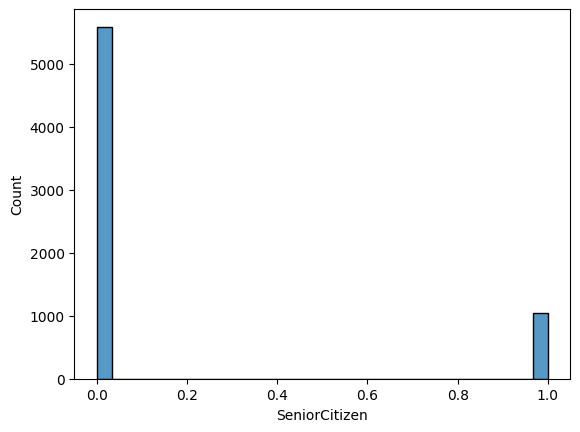

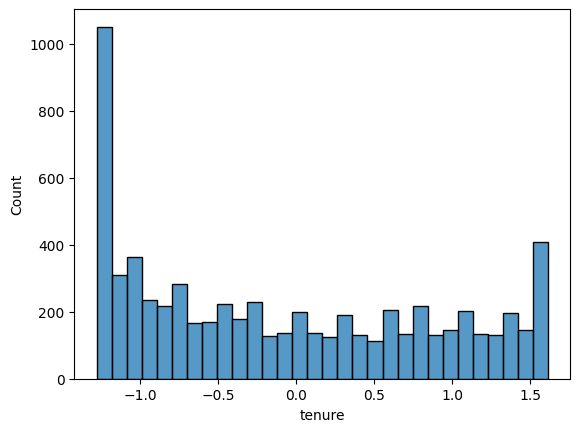

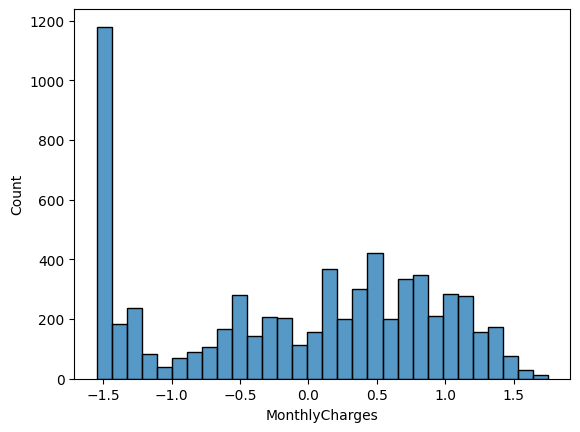

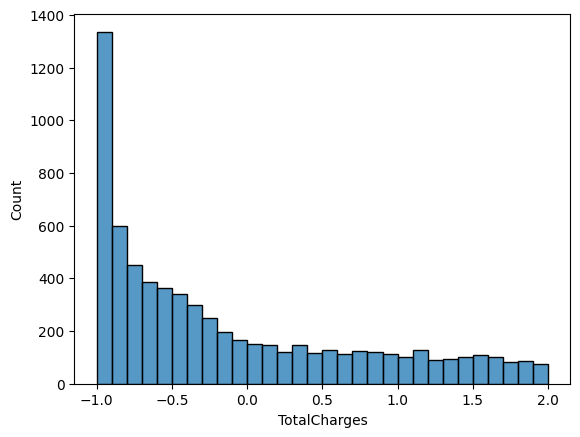

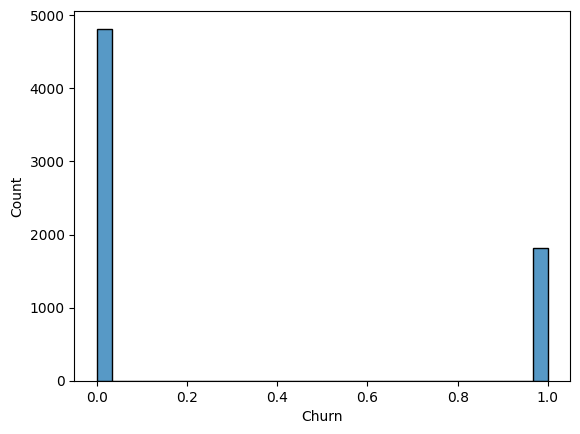

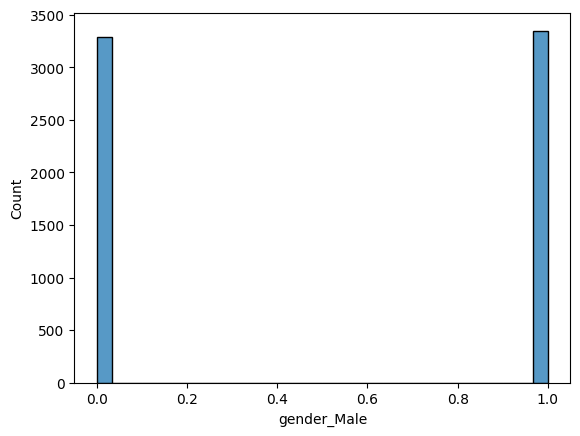

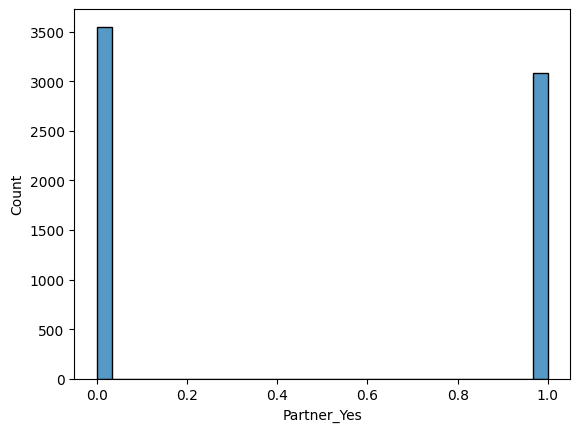

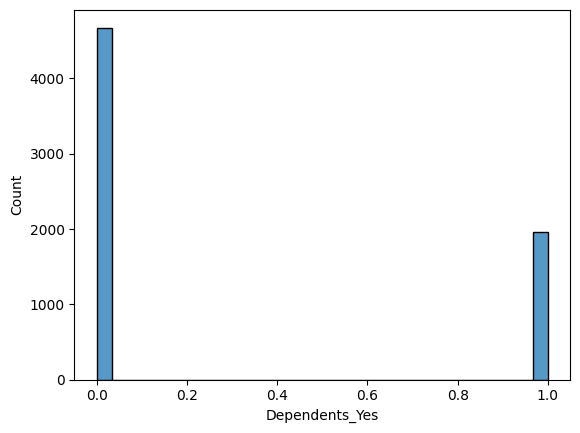

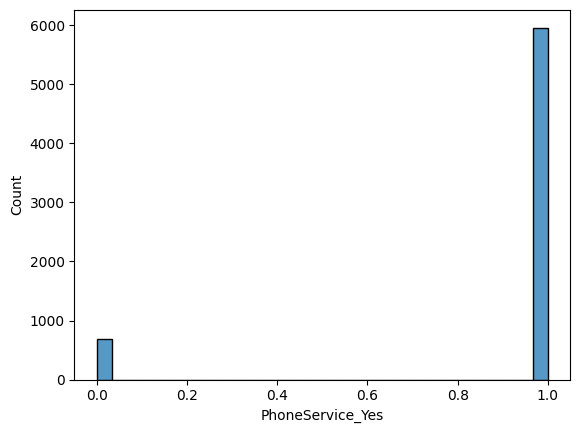

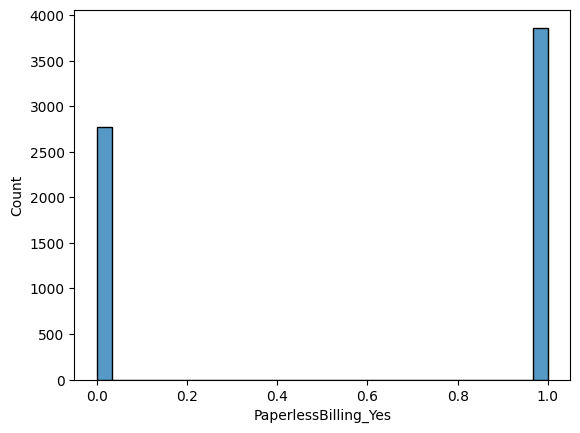

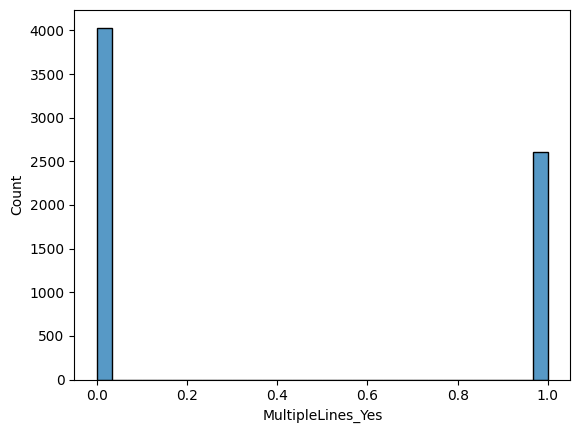

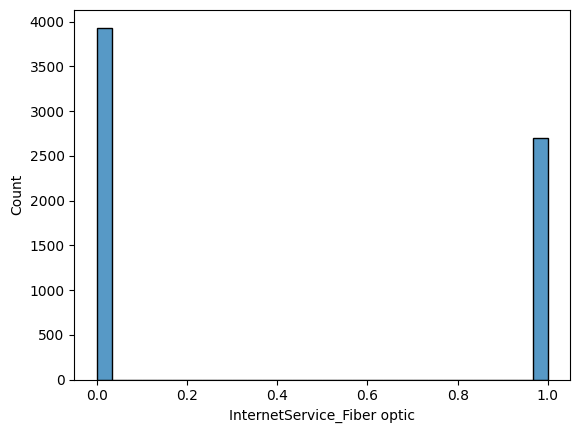

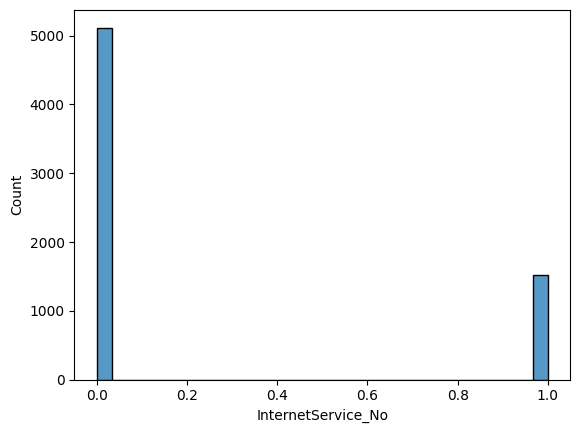

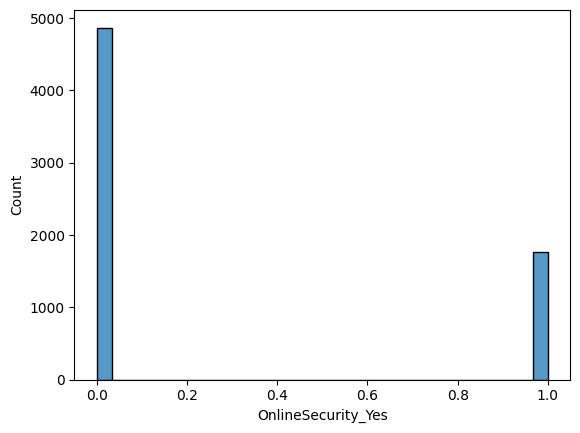

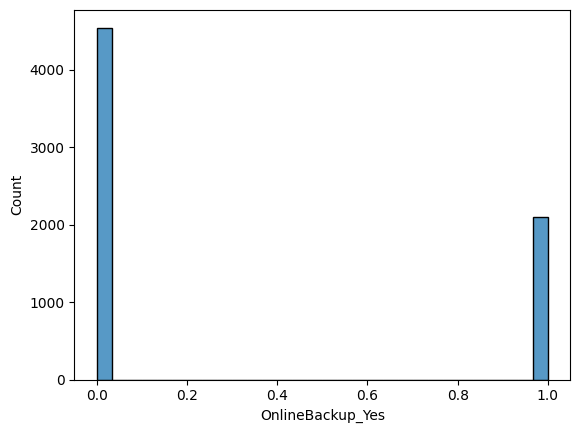

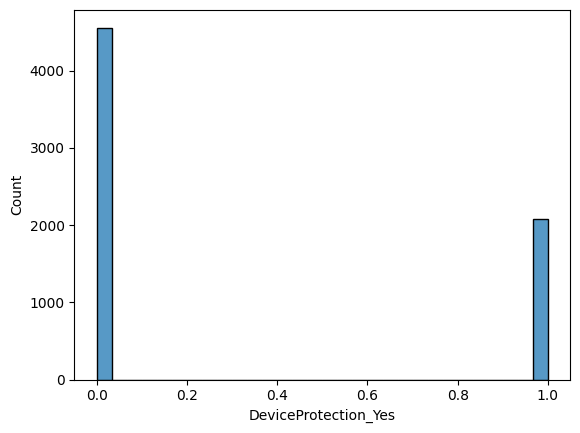

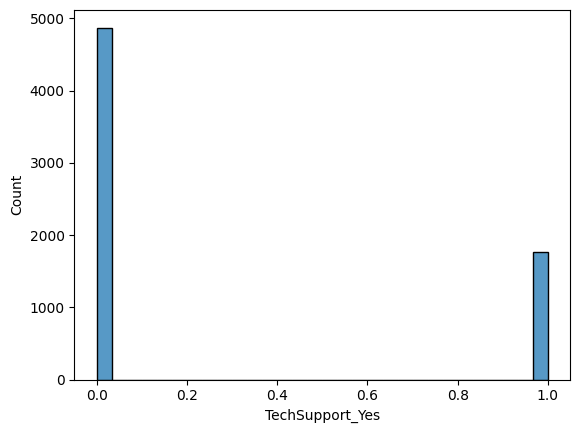

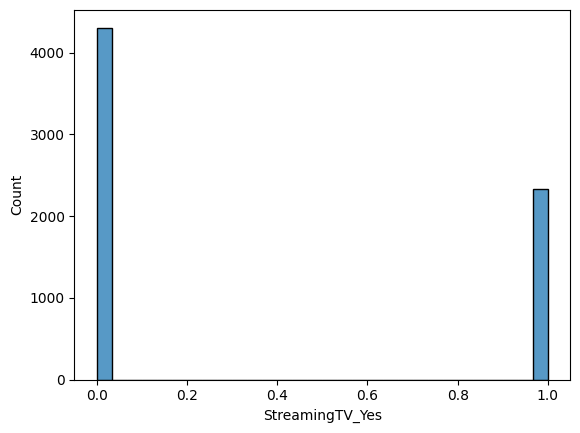

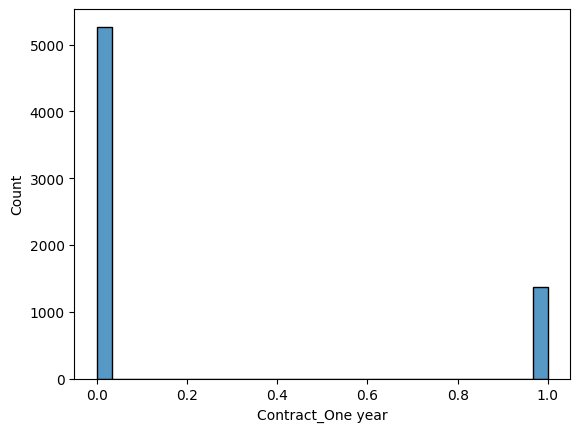

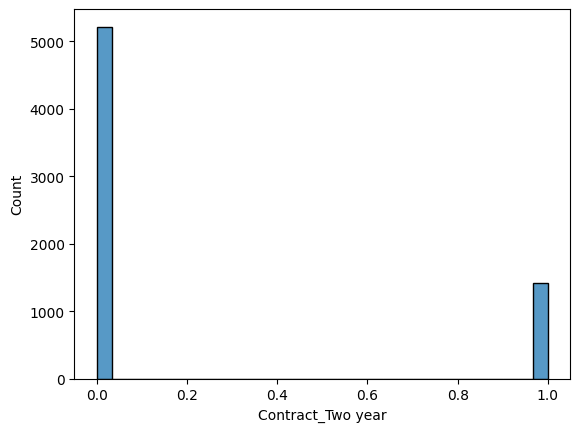

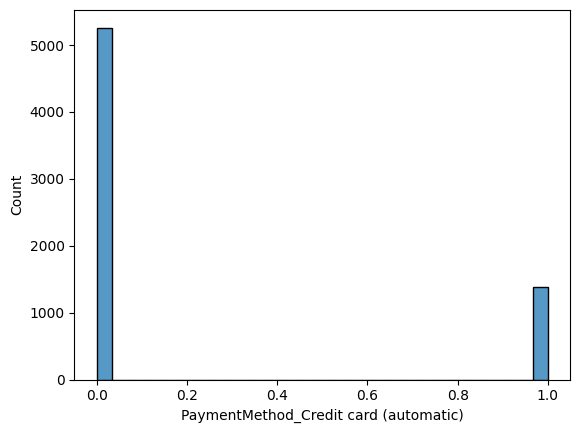

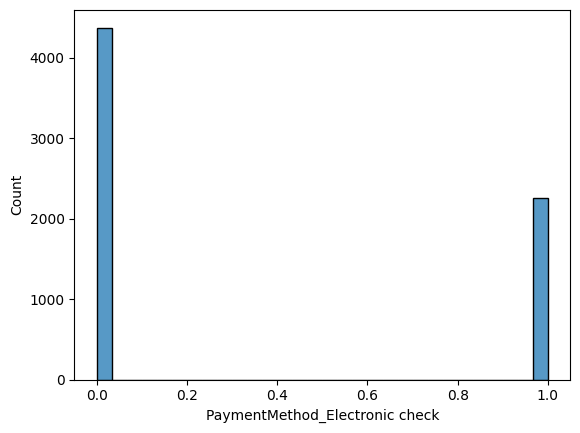

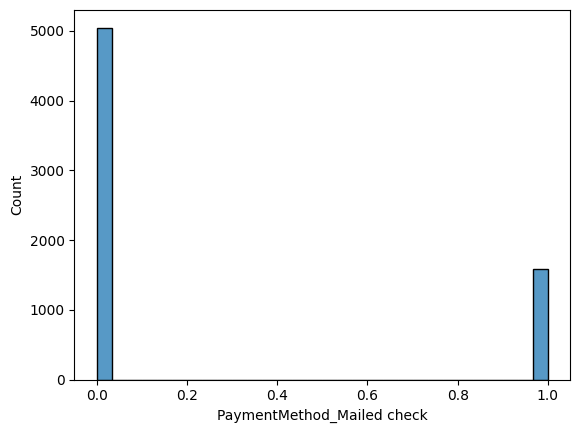

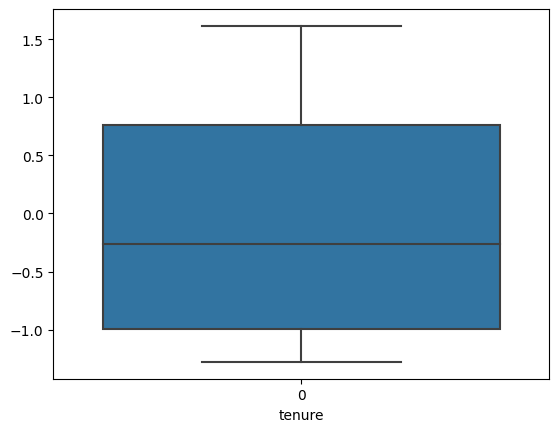

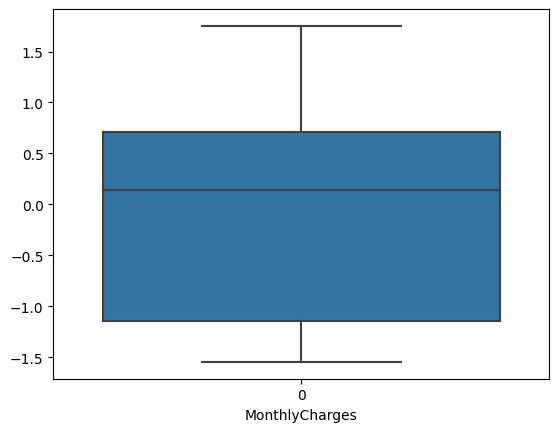

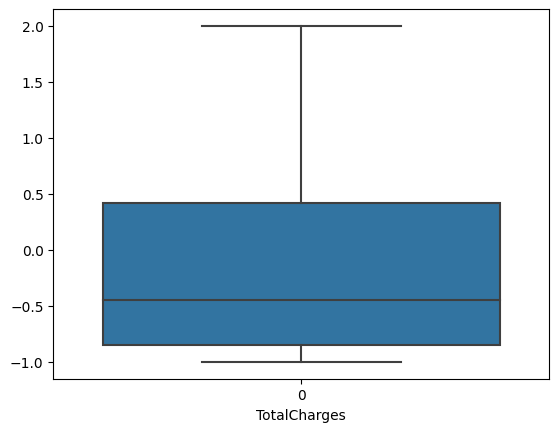

In [58]:
"""main method"""

df = load_data()

df = preprocess_data(df)

explore_data_analytics(df)

In [62]:
X_train, X_test, y_train, y_test = split_data(df)

X_train, X_test = decompose(X_train), decompose(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv




Model : logistic_regression


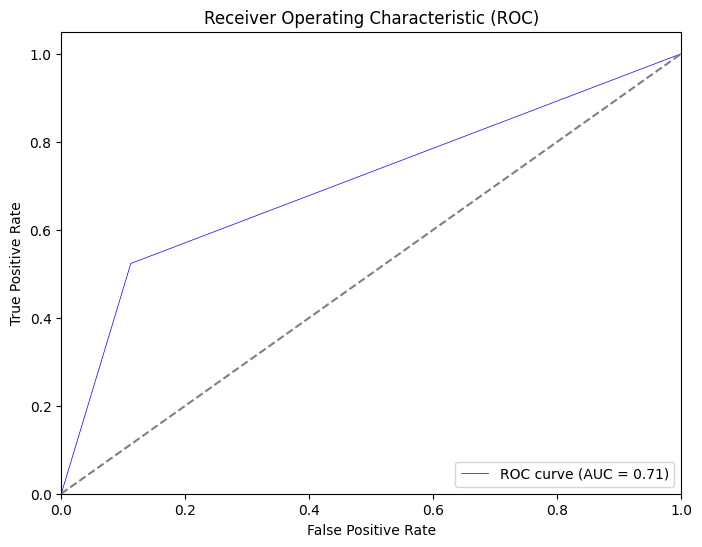




Model : decision_tree


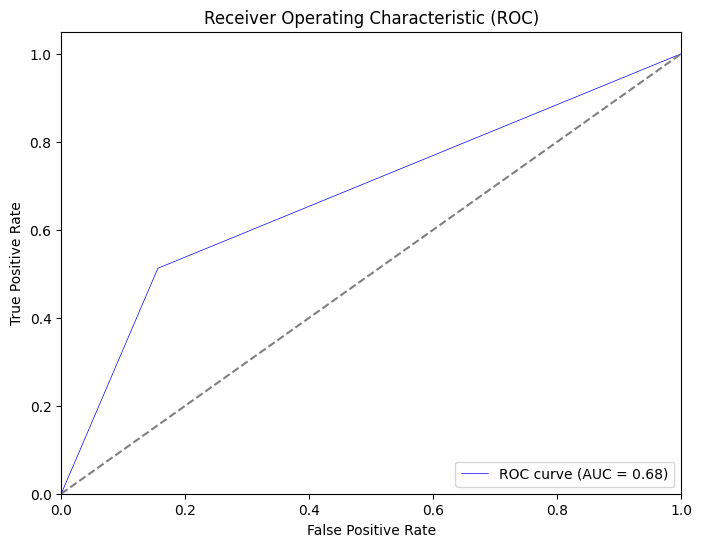




Model : random_forest


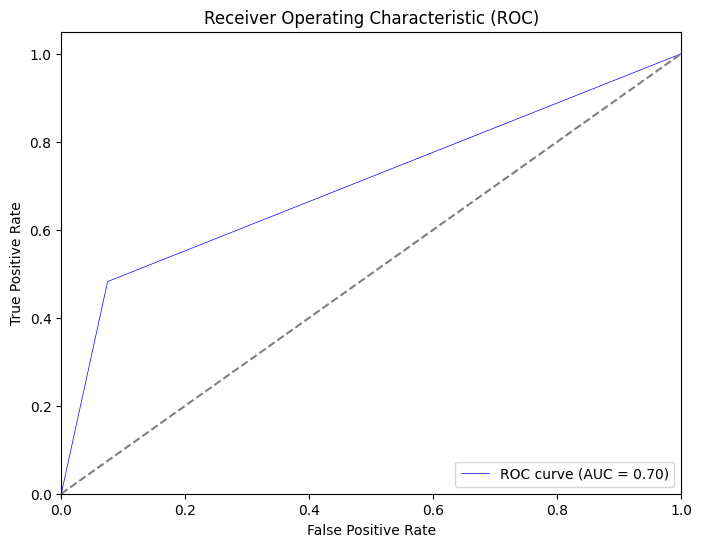




Model : gradient_boosting_machine


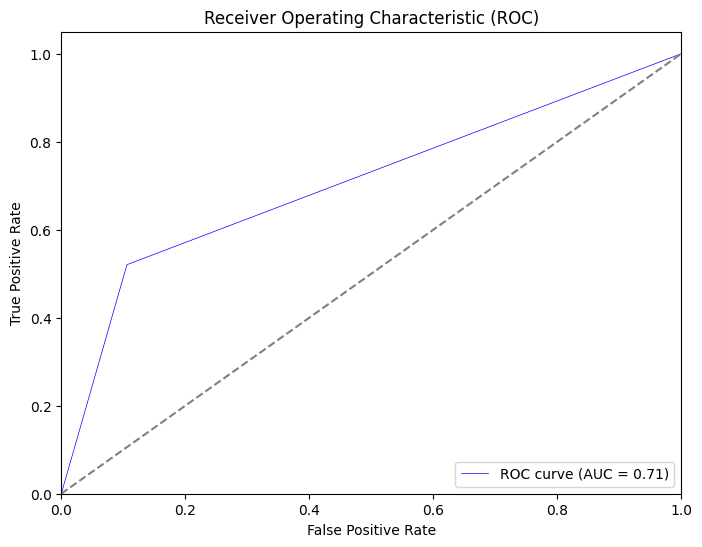

{'logistic_regression': {'accuracy': 0.7876506024096386, 'precision': 0.6387959866220736, 'recall': 0.5232876712328767, 'f1_score': 0.575301204819277, 'confusion_matrix': array([[855, 108],
       [174, 191]]), 'roc_auc_score': 0.7055690692612981}, 'decision_tree': {'accuracy': 0.7530120481927711, 'precision': 0.5548961424332344, 'recall': 0.5123287671232877, 'f1_score': 0.5327635327635327, 'confusion_matrix': array([[813, 150],
       [178, 187]]), 'roc_auc_score': 0.6782827636239491}, 'random_forest': {'accuracy': 0.8034638554216867, 'precision': 0.7096774193548387, 'recall': 0.4821917808219178, 'f1_score': 0.5742251223491027, 'confusion_matrix': array([[891,  72],
       [189, 176]]), 'roc_auc_score': 0.7037127128408655}, 'gradient_boosting_machine': {'accuracy': 0.7914156626506024, 'precision': 0.6506849315068494, 'recall': 0.5205479452054794, 'f1_score': 0.578386605783866, 'confusion_matrix': array([[861, 102],
       [175, 190]]), 'roc_auc_score': 0.7073144710451073}}


In [63]:
models = train_models(X_train, y_train)

evaluation_metrics = evaluate_models(models, X_test, y_test)

In [64]:
print('Best Model :',select_best_model(evaluation_metrics))

Best Model : random_forest
